# Hierarchical, Panel and Global Forecasting with `sktime`

### Overview of this notebook

* introduction - hierarchical time series
* hierarchical and panel data format in sktime
* automated vectorization of forecasters and transformers
* hierarchical reconciliation in sktime
* hierarchical forecasting/Global forecasting using summarization/reduction models, "M5 winner"
* extender guide
* introduction - global forecasting
* global forecast without exogeneous data
* global forecast with exogeneous data
* contributor credits

In [1]:
%%capture
import warnings

warnings.filterwarnings("ignore")

---
## Hierarchical time series

Time series are often present in "hierarchical" form, example:

<img src="./img/hierarchytree.png" width="1200" alt="arrow heads">

Examples include:
* Product sales in different categories (e.g. M5 time series competition)
* Tourism demand in different regions
* Balance sheet structures across cost centers / accounts

Many hierarchical time series datasets can be found here:
https://forecastingdata.org/
(access loader in development)

For literature see also:
https://otexts.com/fpp2/hierarchical.html

A time series can also exhibit multiple independent hierarchies:

<img src="./img/hierarchytree_grouped.png" width="1200" alt="arrow heads">

---

### Representation of hierarchical and panel datatypes

`sktime` distinguishes as abstract scientific data types for time series (="scitypes"):

* `Series` type = one time series (uni or multivariate)
* `Panel` type = collection of multiple time series, flat hierarchy
* `Hierarchical` type = hierarchical collection of time series, as above

Each scitype has multiple mtype representations.

For simplicity, we focus only on `pandas.DataFrame` based representations below.

In [2]:
# import to retrieve examples

from sktime.datatypes import get_examples

#### Individual time series - `Series` scitype, `"pd.DataFrame"` mtype

In the `"pd.DataFrame"` mtype, time series are represented by an in-memory container `obj: pandas.DataFrame` as follows.

* structure convention: `obj.index` must be monotonic, and one of `Int64Index`, `RangeIndex`, `DatetimeIndex`, `PeriodIndex`.
* variables: columns of `obj` correspond to different variables
* variable names: column names `obj.columns`
* time points: rows of `obj` correspond to different, distinct time points
* time index: `obj.index` is interpreted as a time index.
* capabilities: can represent multivariate series; can represent unequally spaced series

Example of a univariate series in `"pd.DataFrame"` representation.\
This series has two variables, named `"a"` and `"b"`. Both are observed at the same four time points 0, 1, 2, 3.

In [3]:
get_examples(mtype="pd.DataFrame")[0]

,a
0,1.0
1,4.0
2,0.5
3,-3.0


Example of a bivariate series in `"pd.DataFrame"` representation.\
This series has two variables, named `"a"` and `"b"`. Both are observed at the same four time points 0, 1, 2, 3.

In [4]:
get_examples(mtype="pd.DataFrame")[1]

,a,b
0,1.0,3.000000
1,4.0,7.000000
2,0.5,2.000000
3,-3.0,-0.428571


#### Panels (= flat collections) of time series - `Panel` scitype, `"pd-multiindex"` mtype

In the `"pd-multiindex"` mtype, time series panels are represented by an in-memory container `obj: pandas.DataFrame` as follows.

* structure convention: `obj.index` must be a pair multi-index of type `(RangeIndex, t)`, where `t` is one of `Int64Index`, `RangeIndex`, `DatetimeIndex`, `PeriodIndex` and monotonic.
* instances: rows with the same `"instances"` index correspond to the same instance; rows with different `"instances"` index correspond to different instances.
* instance index: the first element of pairs in `obj.index` is interpreted as an instance index. 
* variables: columns of `obj` correspond to different variables
* variable names: column names `obj.columns`
* time points: rows of `obj` with the same `"timepoints"` index correspond correspond to the same time point; rows of `obj` with different `"timepoints"` index correspond correspond to the different time points.
* time index: the second element of pairs in `obj.index` is interpreted as a time index. 
* capabilities: can represent panels of multivariate series; can represent unequally spaced series; can represent panels of unequally supported series; cannot represent panels of series with different sets of variables.

Example of a panel of multivariate series in `"pd-multiindex"` mtype representation.
The panel contains three multivariate series, with instance indices 0, 1, 2. All series have two variables with names `"var_0"`, `"var_1"`. All series are observed at three time points 0, 1, 2.

In [5]:
get_examples(mtype="pd-multiindex")[0]

var_0  var_1
instances timepoints              
0         0               1      4
          1               2      5
          2               3      6
1         0               1      4
          1               2     55
          2               3      6
2         0               1     42
          1               2      5
          2               3      6

#### Hierarchical time series - `Hierarchical` scitype, `"pd_multiindex_hier"` mtype

* structure convention: `obj.index` must be a 3 or more level multi-index of type `(RangeIndex, ..., RangeIndex, t)`, where `t` is one of `Int64Index`, `RangeIndex`, `DatetimeIndex`, `PeriodIndex` and monotonic. We call the last index the "time-like" index
* hierarchy level: rows with the same non-time-like indices correspond to the same hierarchy unit; rows with different non-time-like index combination correspond to different hierarchy unit.
* hierarchy: the non-time-like indices in `obj.index` are interpreted as a hierarchy identifying index. 
* variables: columns of `obj` correspond to different variables
* variable names: column names `obj.columns`
* time points: rows of `obj` with the same `"timepoints"` index correspond correspond to the same time point; rows of `obj` with different `"timepoints"` index correspond correspond to the different time points.
* time index: the last element of tuples in `obj.index` is interpreted as a time index. 
* capabilities: can represent hierarchical series; can represent unequally spaced series; can represent unequally supported hierarchical series; cannot represent hierarchical series with different sets of variables.

In [6]:
X = get_examples(mtype="pd_multiindex_hier")[0]
X

var_0  var_1
foo bar timepoints              
a   0   0               1      4
        1               2      5
        2               3      6
    1   0               1      4
        1               2     55
        2               3      6
    2   0               1     42
        1               2      5
        2               3      6
b   0   0               1      4
        1               2      5
        2               3      6
    1   0               1      4
        1               2     55
        2               3      6
    2   0               1     42
        1               2      5
        2               3      6

In [7]:
X.index.get_level_values(level=-1)

Index([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2], dtype='int64', name='timepoints')

---

### Automated vectorization (casting) of forecasters and transformers

Many transformers and forecasters implemented for single series

`sktime` automatically vectorizes/"up-casts" them to hierarchical data

"apply by individual series/panel in the hierarchical structure"

constructing a hierarchical time series:

In [8]:
from sktime.utils._testing.hierarchical import _make_hierarchical

y = _make_hierarchical()
y

c0
h0   h1   time                
h0_0 h1_0 2000-01-01  5.362957
          2000-01-02  3.754092
          2000-01-03  3.694620
          2000-01-04  4.505095
          2000-01-05  4.258019
...                        ...
h0_1 h1_3 2000-01-08  5.570945
          2000-01-09  3.900855
          2000-01-10  3.176134
          2000-01-11  5.399588
          2000-01-12  1.000000

[96 rows x 1 columns]

all forecasters and transformers are applicable to this!\
if forecaster implements logic for single series only, "apply to all hierarchy units"

In [9]:
from sktime.forecasting.arima import ARIMA

forecaster = ARIMA()

y_pred = forecaster.fit(y, fh=[1, 2]).predict()
y_pred

c0
h0   h1   time                
h0_0 h1_0 2000-01-13  4.322252
          2000-01-14  4.350084
     h1_1 2000-01-13  4.167253
          2000-01-14  4.342375
     h1_2 2000-01-13  3.691584
          2000-01-14  4.840444
     h1_3 2000-01-13  4.696280
          2000-01-14  4.747535
h0_1 h1_0 2000-01-13  4.737524
          2000-01-14  4.690233
     h1_1 2000-01-13  3.794091
          2000-01-14  3.789514
     h1_2 2000-01-13  4.136015
          2000-01-14  4.175891
     h1_3 2000-01-13  6.248877
          2000-01-14  3.154669

individual forecasters fitted per hierarchy level are stored in the  `forecasters_` attribute\
this contains a `pandas.DataFrame` in the same format as the hierarchy levels, and fitted forecasters inside\
(for transformers, the attribute is called `transformers_`)

In [10]:
forecaster.forecasters_

forecasters
h0_0 h1_0     ARIMA()
     h1_1     ARIMA()
     h1_2     ARIMA()
     h1_3     ARIMA()
h0_1 h1_0     ARIMA()
     h1_1     ARIMA()
     h1_2     ARIMA()
     h1_3     ARIMA()

to access or inspect individual forecasters, access elements of the `forecasters_` data frame:

In [11]:
forecaster.forecasters_.iloc[0, 0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -18.519
Date:                Tue, 13 Aug 2024   AIC                             43.037
Time:                        18:00:56   BIC                             44.492
Sample:                    01-01-2000   HQIC                            42.499
                         - 01-12-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9667      1.390      2.854      0.004       1.243       6.691
ar.L1          0.0887      0.316      0.281      0.779      -0.531       0.708
sigma2         1.2813      0.671      1.909      0.056      -0.034       2.597
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.84   Prob(JB):                         0.87
Heteroskedasticity (H):               4.30   Skew:                             0.05
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

auto-vectorization is also performed for probabilistic forecasts (see notebook 2):

In [12]:
forecaster.predict_interval()

c0          
                           0.9          
                         lower     upper
h0   h1   time                          
h0_0 h1_0 2000-01-13  2.460338  6.184165
          2000-01-14  2.480860  6.219309
     h1_1 2000-01-13  2.383353  5.951154
          2000-01-14  2.404729  6.280021
     h1_2 2000-01-13  2.043580  5.339587
          2000-01-14  2.977707  6.703181
     h1_3 2000-01-13  3.071368  6.321193
          2000-01-14  3.118729  6.376342
h0_1 h1_0 2000-01-13  3.919035  5.556013
          2000-01-14  3.860632  5.519834
     h1_1 2000-01-13  2.709243  4.878939
          2000-01-14  2.704623  4.874405
     h1_2 2000-01-13  1.998229  6.273801
          2000-01-14  1.990215  6.361568
     h1_3 2000-01-13  4.244239  8.253514
          2000-01-14  0.827640  5.481698

which level a forecaster/natively implements and when vectorization occurs is determined by the "inner mtype" attributes.

For forecasters, inspect `y_inner_mtype`, this is a list of internally supported machine types:

In [13]:
forecaster.get_tag("y_inner_mtype")

'pd.Series'

ARIMA supports only one `Series` level mtype.
For a register of all mtype codes and their corresponding scitype (series, panel or hierarchical),\
see `sktime.datatypes.MTYPE_REGISTER` (convert to `pandas.DataFrame` for pretty-printing)

In [14]:
import pandas as pd

from sktime.datatypes import MTYPE_REGISTER

pd.DataFrame(MTYPE_REGISTER)

,0,1,2
0,pd.Series,Series,pd.Series representation of a univariate series
1,pd.DataFrame,Series,pd.DataFrame representation of a uni- or multi...
2,np.ndarray,Series,"2D numpy.ndarray with rows=samples, cols=varia..."
3,xr.DataArray,Series,xr.DataArray representation of a uni- or multi...
4,dask_series,Series,xdas representation of a uni- or multivariate ...
5,gluonts_ListDataset_series,Series,gluonTS representation of univariate and multi...
6,nested_univ,Panel,"pd.DataFrame with one column per variable, pd...."
7,numpy3D,Panel,"3D np.array of format (n_instances, n_columns,..."
8,numpyflat,Panel,"WARNING: only for internal use, not a fully su..."
9,pd-multiindex,Panel,"pd.DataFrame with multi-index (instances, time..."


roadmap items:

* interfacing and implementing common methods with native hierarchical support
    * ARIMA using hierarchy factors, GEE, mixed effects
* wrappers for "using hierarchy levels" as covariates or exogeneous features
* full vectorization over variables to render univariate forecasters multivariate

contributions are appreciated!

---

### Hierarchical reconciliation

#### Why do we need hierarchical reconciliation

forecast reconciliation = ensuring that linear hierarchy dependencies are met,\
e.g., "sum of individual shop sales in Berlin must equal sum of total sales in Berlin"\
requires hierarchical (or panel) data, usually involves totals

**Bottom up reconciliation** works by producing only forecasts at the lowest level and then adding up to totals across all higher levels. 

    * Arguably the most simple of all algorithms to reconcile across hierarchies.
    * Advantages: easy to implement
    * Disadvantages: lower levels of hierarchy are prone to excess volatility. This excess volatility is aggregated up, often producing much less accurate top level forecasts.

**Top down reconciliation** works by producing top level forecasts and breaking them down to  the lowest level based e.g. on relative proportions of those lower levels.

    * Advantages: still easy to implement, top level is stable
    * Disadvantages: peculiarities of lower levels of hierarchy ignored

**Optimal forecast reconciliation** works by producing forecasts at all levels of the hierarchy and adjusting all of them in a way that seeks to minimize the forecast errors

    * Advantages: often found to be most accurate implementation
    * Disadvantages: more difficult to implement

`sktime` provides functionality for reconciliation:

* data container convention for node-wise aggregates
* functionality to compute node-wise aggregates - `Aggregator`
    * can be used for bottom-up reconciliation
* transformer implementing reconiliation logic - `Reconciler`
    * implements top-down reconciliation
    * implements transformer-like optimal forecast reconciliation

#### The node-wise aggregate data format

`sktime` uses a special case of the `pd_multiindex_hier` format to store node-wise aggregates:

* a `__total` index element in an instance (non-time-like) level indicates summation over all instances below that level
* the `__total` index element is reserved and cannot be used for anything else
* entries below a `__total` index element are sums of entries over all other instances in the same levels where a `__total` element is found

#### The aggregation transformer

The node-wise aggregated format can be obtained by applying the `Aggregator` transformer.

In a pipeline with non-aggregate dinput, this allows making forecasts by totals.

In [15]:
from sktime.datatypes import get_examples

y_hier = get_examples("pd_multiindex_hier")[1]
y_hier

var_0
foo bar timepoints       
a   0   0               1
        1               2
        2               3
    1   0               1
        1               2
        2               3
    2   0               1
        1               2
        2               3
b   0   0               1
        1               2
        2               3
    1   0               1
        1               2
        2               3
    2   0               1
        1               2
        2               3

In [16]:
from sktime.transformations.hierarchical.aggregate import Aggregator

Aggregator().fit_transform(y_hier)

var_0
foo     bar     timepoints       
__total __total 0               6
                1              12
                2              18
a       0       0               1
                1               2
                2               3
        1       0               1
                1               2
                2               3
        2       0               1
                1               2
                2               3
        __total 0               3
                1               6
                2               9
b       0       0               1
                1               2
                2               3
        1       0               1
                1               2
                2               3
        2       0               1
                1               2
                2               3
        __total 0               3
                1               6
                2               9

If used at the start of a pipeline, forecasts are made for node `__total`-s as well as individual instances.

Note: in general, this does not result in a reconciled forecast, i.e., forecast totals will not add up.

In [17]:
from sktime.forecasting.naive import NaiveForecaster

pipeline_to_forecast_totals = Aggregator() * NaiveForecaster()

pipeline_to_forecast_totals.fit(y_hier, fh=[1, 2])
pipeline_to_forecast_totals.predict()

var_0
foo     bar     timepoints       
__total __total 3            18.0
                4            18.0
a       0       3             3.0
                4             3.0
        1       3             3.0
                4             3.0
        2       3             3.0
                4             3.0
        __total 3             9.0
                4             9.0
b       0       3             3.0
                4             3.0
        1       3             3.0
                4             3.0
        2       3             3.0
                4             3.0
        __total 3             9.0
                4             9.0

If used at the end of a pipeline, forecasts are reconciled bottom-up.

That will result in a reconciled forecast, although bottom-up may not be the method of choice.

In [18]:
from sktime.forecasting.naive import NaiveForecaster

pipeline_to_forecast_totals = NaiveForecaster() * Aggregator()

pipeline_to_forecast_totals.fit(y_hier, fh=[1, 2])
pipeline_to_forecast_totals.predict()

var_0
foo     bar     timepoints       
__total __total 3            18.0
                4            18.0
a       0       3             3.0
                4             3.0
        1       3             3.0
                4             3.0
        2       3             3.0
                4             3.0
        __total 3             9.0
                4             9.0
b       0       3             3.0
                4             3.0
        1       3             3.0
                4             3.0
        2       3             3.0
                4             3.0
        __total 3             9.0
                4             9.0

#### Advanced reconciliation

For transformer-like reconciliation, use the `Reconciler`.
It supports advanced techniques such as OLS and WLS:

In [19]:
from sktime.transformations.hierarchical.reconcile import Reconciler

pipeline_with_reconciliation = (
    Aggregator() * NaiveForecaster() * Reconciler(method="ols")
)

In [20]:
pipeline_to_forecast_totals.fit(y_hier, fh=[1, 2])
pipeline_to_forecast_totals.predict()

var_0
foo     bar     timepoints       
__total __total 3            18.0
                4            18.0
a       0       3             3.0
                4             3.0
        1       3             3.0
                4             3.0
        2       3             3.0
                4             3.0
        __total 3             9.0
                4             9.0
b       0       3             3.0
                4             3.0
        1       3             3.0
                4             3.0
        2       3             3.0
                4             3.0
        __total 3             9.0
                4             9.0

Roadmap items:

* reconciliation of wrapper type
* reconciliation & Global forecasting
* probabilistic reconciliation

---

## Global forecasting in `sktime`

### Global forecasting/Panel forecasting - introduction

Global forecasting = training **across sets of time series**, i.e., on time series **panels**.\
Typically better than "fit one forecaster per time series instance".

Also called:

* "panel forecasting", if forecasting all time series
* "cross-learning", if training time series are disjoint from deployment set

 Why does Global forecasting matter?

 * In practice, we often have time series of limited range
 * Estimation is difficult, and we cannot model complex dependencies
 * Assumption of Global forecasting: We can observe the identical data generating process (DGP) multiple times
 * Non-identical DGPs can be fine too, as long as the degree of dissimilarity is captured by exogeneous information
 * Now we have much more information and can estimate more reliably and more complex models (caveat: unless complexity is purely driven by time dynamics)
 
As a result of these advantages, Global forecasting models have been very successful in competition, e.g.
* Rossmann Store Sales
* Walmart Sales in Stormy Weather
* M5 competition

Many business problems in practice are essentially Global forecasting problem - often also reflecting hierarchical information (see above)
* Product sales in different categories (e.g. M5 time series competition)
* Balance sheet structures across cost centers / accounts
* Dynamics of pandemics observed at different points in time

Distinction to multivariate forecasting
* Multivariate forecasting focuses on modeling interdependence between time series
* Global forecasting can model interdependence, but focus lies on enhancing observation space

Implementation in sktime

* All models support panel forecasts - these may be independent or dependent
    * some models' panel forecasts use all time series, e.g., reduction forecasters
* Models that can train on disjoint examples ("cross-learning") have the `capability:global_forecasting` tag

### Panel forecasting with reduction forecasters

For the following example we will use the `"pd-multiindex"` representation of the `"Panel"` scitype (see above)

Row multiindex level 0 is the unique identifier for the individual time series, level 1 contains the time index.

In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

from sktime.forecasting.compose import make_reduction
from sktime.split import temporal_train_test_split
from sktime.transformations.series.date import DateTimeFeatures

pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", None)

# %%
# Load M5 Data and prepare
y = pd.read_pickle("global_fc/y.pkl")
X = pd.read_pickle("global_fc/X.pkl")

`y`/`X` are based on the M5 competition.
The data features sales of products in different stores, different states and different product categories. 

For a detailed analysis of the competition please take a look at the paper 
"M5 accuracy competition: Results, findings, and conclusions".

https://doi.org/10.1016/j.ijforecast.2021.11.013

You can see 
a glimpse of the data here:

In [22]:
print(y.head())
print(X.head())

                            y
instances timepoints         
1         2016-03-15   756.67
          2016-03-16   679.13
          2016-03-17   633.40
          2016-03-18  1158.04
          2016-03-19   914.24
                      dept_id  cat_id  store_id  state_id  event_name_1  \
instances timepoints                                                      
1         2016-03-15        1       1        10         3             1   
          2016-03-16        1       1        10         3             1   
          2016-03-17        1       1        10         3             7   
          2016-03-18        1       1        10         3             1   
          2016-03-19        1       1        10         3             1   

                      event_type_1  event_name_2  event_type_2  snap  \
instances timepoints                                                   
1         2016-03-15             1             1             1     3   
          2016-03-16             1             1


* time series grouped via the instances argument in the first column = Panel
* focus on modeling individual products
* hierarchical information is provided as exgoneous information. 

For the M5 competition, winning solution used exogeneous features about the hierarchies like `"dept_id"`, `"store_id"` etc. to capture similarities and dissimilarities of the products. Other features include holiday events and snap days (specific assistance program of US social security paid on certain days).

now split into test and train set using `temporal_train_test_split`.\
we can cut every instance of the time series individually:


In [23]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)
print(y_train.head(5))
print(y_test.head(5))

                            y
instances timepoints         
1         2016-03-15   756.67
          2016-03-16   679.13
          2016-03-17   633.40
          2016-03-18  1158.04
          2016-03-19   914.24
                            y
instances timepoints         
1         2016-04-14   874.57
          2016-04-15   895.29
          2016-04-16  1112.63
          2016-04-17  1014.86
          2016-04-18   691.91


both `y` and `X` are split in the same way, and hierarchy structures are preserved.

#### Rationale for tree based models

Tree ensembles exploit complex non-linear relationships / dependencies between time series and covariates.

In **univariate time series forecasting**, tree based models often do not perform well due to lack of data.

Due to large effective sample sizes in **Global forecasting** , tree ensembles can become a good choice (e.g., 42,840 time series in the M5 competition).

sktime can interface any sklearn compatible model via reduction, e.g., `RandomForestRegressor`.

In [24]:
regressor = make_pipeline(
    RandomForestRegressor(random_state=1),
)

Caveat: reduction applies a supervised regressor to a time series, i.e., to a task for which they were not originally designed.

This issue can be addressed by generating features that capture the dynamics of the time series.\
`"WindowSummarizer"` can be used to generate features useful for time series forecasting,\
 based on a provided dictionary of functions, window shifts and window lengths:

In [25]:
import pandas as pd

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.summarize import WindowSummarizer

kwargs = {
    "lag_feature": {
        "lag": [1],
        "mean": [[1, 3], [3, 6]],
        "std": [[1, 4]],
    }
}

transformer = WindowSummarizer(**kwargs)
y_transformed = transformer.fit_transform(y_train)

y_transformed.head(10)

/home/xinyu/DATA1_1T/anaconda3/envs/sktime_310/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/xinyu/DATA1_1T/anaconda3/envs/sktime_310/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/xinyu/DATA1_1T/anaconda3/envs/sktime_310/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/xinyu/DATA1_1T/anaconda3/envs/sktime_310/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and de

y_lag_1   y_mean_1_3  y_mean_3_6   y_std_1_4
instances timepoints                                              
1         2016-03-15      NaN          NaN         NaN         NaN
          2016-03-16   756.67          NaN         NaN         NaN
          2016-03-17   679.13          NaN         NaN         NaN
          2016-03-18   633.40   689.733333         NaN         NaN
          2016-03-19  1158.04   823.523333         NaN  239.617572
          2016-03-20   914.24   901.893333         NaN  241.571143
          2016-03-21   965.27  1012.516667         NaN  216.690775
          2016-03-22   630.77   836.760000         NaN  217.842052
          2016-03-23   702.79   766.276667  851.125000  161.669232
          2016-03-24   728.15   687.236667  830.141667  145.007117

The notation `"mean": [[1, 3]]` (captured in the column `"y_mean_1_3"`) is read as:

summarization function `"mean": [[1, 3]]` is applied to:

* window of length 3
* start (inclusive) is lagged by one period

Visualization:

For z = target time stamp:\
`window = [1, 3]`, means a `lag` of 1 and `window_length` of 3, selecting the three last days (exclusive z).

Summarization is done across windows like this:

| x x x x x x x x * * * z x |
|---------------------------|

By default, `"WindowSummarizer"` uses pandas rolling window functions to allow for a speedy generation of features. 
* "sum",
* "mean",
* "median",
* "std",
* "var",
* "kurt",
* "min",
* "max",
* "corr",
* "cov",
* "skew",
* "sem"

typically very fast since optimized for rolling, grouped operations

In the M5 competition, arguably the most relevant features were:

* **mean** calculations to capture level shifts, e.g. last week sales, sales of the week prior to the last month etc.
* **standard deviation** to capture increases / decreases in volatility in sales, and how it impacts future sales
* rolling **skewness** / **kurtosis** calculations, to capture changes in store sales tendencies.
* various different calculations to capture periods of zero sales (e.g. out of stock scenarios)

First three are available via native pandas functions.\
`WindowSummarizer` can also be provided with arbitrary summarizer functions.

Example: function `count_gt130` to count how many observations lie above the threshold of 130 within a window of length 3, lagged by 2 periods.

In [26]:
import numpy as np


def count_gt130(x):
    """Count how many observations lie above threshold 130."""
    return np.sum((x > 700)[::-1])


kwargs = {
    "lag_feature": {
        "lag": [1],
        count_gt130: [[2, 3]],
        "std": [[1, 4]],
    }
}

transformer = WindowSummarizer(**kwargs)
y_transformed = transformer.fit_transform(y_train)

y_transformed.head(10)

/home/xinyu/DATA1_1T/anaconda3/envs/sktime_310/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/xinyu/DATA1_1T/anaconda3/envs/sktime_310/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/xinyu/DATA1_1T/anaconda3/envs/sktime_310/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


y_lag_1  y_count_gt130_2_3   y_std_1_4
instances timepoints                                        
1         2016-03-15      NaN                NaN         NaN
          2016-03-16   756.67                NaN         NaN
          2016-03-17   679.13                NaN         NaN
          2016-03-18   633.40                NaN         NaN
          2016-03-19  1158.04                1.0  239.617572
          2016-03-20   914.24                1.0  241.571143
          2016-03-21   965.27                2.0  216.690775
          2016-03-22   630.77                3.0  217.842052
          2016-03-23   702.79                2.0  161.669232
          2016-03-24   728.15                2.0  145.007117

Above applies `"WindowSummarizer"` to the forecasting targey `y`.

To apply `"WindowSummarizer"` to columns in `X`, use `"WindowSummarizer"` within a `"ForecastingPipeline"` and specify `"target_cols"`.

In the M5 competition, lagging of exogeneous features was especially useful for lags around holiday dummies (often sales are affected for a few days before and after major holidays) as well as changes in item prices (discounts as well as persistent price changes)

In [27]:
from sktime.datasets import load_longley
from sktime.forecasting.naive import NaiveForecaster

y_ll, X_ll = load_longley()
y_train_ll, y_test_ll, X_train_ll, X_test_ll = temporal_train_test_split(y_ll, X_ll)
fh = ForecastingHorizon(X_test_ll.index, is_relative=False)
# Example transforming only X
pipe = ForecastingPipeline(
    steps=[
        ("a", WindowSummarizer(n_jobs=1, target_cols=["POP", "GNPDEFL"])),
        ("b", WindowSummarizer(n_jobs=1, target_cols=["GNP"], **kwargs)),
        ("forecaster", NaiveForecaster(strategy="drift")),
    ]
)
pipe_return = pipe.fit(y_train_ll, X_train_ll)
y_pred1 = pipe_return.predict(fh=fh, X=X_test_ll)

y_pred1

Period
1959    67075.727273
1960    67638.454545
1961    68201.181818
1962    68763.909091
Freq: Y-DEC, Name: TOTEMP, dtype: float64

For efficiency, relevant features are computed in a parallel way.\
For maximum parallelization, pass `WindowSummarizer` as a single transformer within `make_reduction`. 

In this case, `window_length` is inferred from the `WindowSummarizer` and need not be passed to `make_reduction`.

In [28]:
forecaster = make_reduction(
    regressor,
    transformers=[WindowSummarizer(**kwargs, n_jobs=1)],
    window_length=None,
    strategy="recursive",
    pooling="global",
)

Concepts relating to calendar seasonalities need to be provided by means of feature engineering to most models. Examples:

* day of the week effects historically observed for stock prices (prices on Fridays used to differ from Monday prices).
* used car prices being higher in spring than in summer
* spendings at the beginning of the month differing from end of month due to salary effects.

Calendar seasonalities can be modeled by means of dummy variables or fourier terms. As a rule of thumb, use dummy variables for discontinuous effects and fourier/period/seasonality terms when you believe there is a certain degree of smoothness in the seasonality.

`sktime` supports calendar dummy features via the `DateTimeFeatures` transformer. Manually specify the desired seasonality, or provide base frequency of the time series (daily, weekly etc.) and the desired complexity (few vs many features), `DateTimeFeatures` can infer sensible seasonality.

In [29]:
transformer = DateTimeFeatures(ts_freq="D")
X_hat = transformer.fit_transform(X_train)

new_cols = [i for i in X_hat if i not in X_train.columns]
X_hat[new_cols]

year  month_of_year  day_of_week
instances timepoints                                  
1         2016-03-15  2016              3            1
          2016-03-16  2016              3            2
          2016-03-17  2016              3            3
          2016-03-18  2016              3            4
          2016-03-19  2016              3            5
          2016-03-20  2016              3            6
          2016-03-21  2016              3            0
          2016-03-22  2016              3            1
          2016-03-23  2016              3            2
          2016-03-24  2016              3            3
          2016-03-25  2016              3            4
          2016-03-26  2016              3            5
          2016-03-27  2016              3            6
          2016-03-28  2016              3            0
          2016-03-29  2016              3            1
          2016-03-30  2016              3            2
          2016-03-31  2016              3            3
          2016-04-01  2016              4            4
          2016-04-02  2016              4            5
          2016-04-03  2016              4            6
          2016-04-04  2016              4            0
          2016-04-05  2016              4            1
          2016-04-06  2016              4            2
          2016-04-07  2016              4            3
          2016-04-08  2016              4            4
          2016-04-09  2016              4            5
          2016-04-10  2016              4            6
          2016-04-11  2016              4            0
          2016-04-12  2016              4            1
          2016-04-13  2016              4            2
2         2016-03-15  2016              3            1
          2016-03-16  2016              3            2
          2016-03-17  2016              3            3
          2016-03-18  2016              3            4
          2016-03-19  2016              3            5
          2016-03-20  2016              3            6
          2016-03-21  2016              3            0
          2016-03-22  2016              3            1
          2016-03-23  2016              3            2
          2016-03-24  2016              3            3
          2016-03-25  2016              3            4
          2016-03-26  2016              3            5
          2016-03-27  2016              3            6
          2016-03-28  2016              3            0
          2016-03-29  2016              3            1
          2016-03-30  2016              3            2
          2016-03-31  2016              3            3
          2016-04-01  2016              4            4
          2016-04-02  2016              4            5
          2016-04-03  2016              4            6
          2016-04-04  2016              4            0
          2016-04-05  2016              4            1
          2016-04-06  2016              4            2
          2016-04-07  2016              4            3
          2016-04-08  2016              4            4
          2016-04-09  2016              4            5
          2016-04-10  2016              4            6
          2016-04-11  2016              4            0
          2016-04-12  2016              4            1
          2016-04-13  2016              4            2

DateTimeFeatures supports the following frequencies:
* Y - year
* Q - quarter
* M - month
* W - week
* D - day
* H - hour
* T - minute
* S - second
* L - millisecond

You can specify the manual generation of dummy features with the notation e.g. "day_of_month", "day_of_week", "week_of_quarter". 

In [30]:
transformer = DateTimeFeatures(manual_selection=["week_of_month", "day_of_quarter"])
X_hat = transformer.fit_transform(X_train)

new_cols = [i for i in X_hat if i not in X_train.columns]
X_hat[new_cols]

day_of_quarter  week_of_month
instances timepoints                               
1         2016-03-15              75              3
          2016-03-16              76              3
          2016-03-17              77              3
          2016-03-18              78              3
          2016-03-19              79              3
          2016-03-20              80              3
          2016-03-21              81              3
          2016-03-22              82              4
          2016-03-23              83              4
          2016-03-24              84              4
          2016-03-25              85              4
          2016-03-26              86              4
          2016-03-27              87              4
          2016-03-28              88              4
          2016-03-29              89              5
          2016-03-30              90              5
          2016-03-31              91              5
          2016-04-01               1              1
          2016-04-02               2              1
          2016-04-03               3              1
          2016-04-04               4              1
          2016-04-05               5              1
          2016-04-06               6              1
          2016-04-07               7              1
          2016-04-08               8              2
          2016-04-09               9              2
          2016-04-10              10              2
          2016-04-11              11              2
          2016-04-12              12              2
          2016-04-13              13              2
2         2016-03-15              75              3
          2016-03-16              76              3
          2016-03-17              77              3
          2016-03-18              78              3
          2016-03-19              79              3
          2016-03-20              80              3
          2016-03-21              81              3
          2016-03-22              82              4
          2016-03-23              83              4
          2016-03-24              84              4
          2016-03-25              85              4
          2016-03-26              86              4
          2016-03-27              87              4
          2016-03-28              88              4
          2016-03-29              89              5
          2016-03-30              90              5
          2016-03-31              91              5
          2016-04-01               1              1
          2016-04-02               2              1
          2016-04-03               3              1
          2016-04-04               4              1
          2016-04-05               5              1
          2016-04-06               6              1
          2016-04-07               7              1
          2016-04-08               8              2
          2016-04-09               9              2
          2016-04-10              10              2
          2016-04-11              11              2
          2016-04-12              12              2
          2016-04-13              13              2

#### Putting it all together

Using the `"WindowSummarizer"`, `"DateTimeFeatures"` and the `"make_reduction"` function we can now set up a working example of a an end to end Global forecasting pipeline based on a sample of the M5 competition data:

In [31]:
pipe = ForecastingPipeline(
    steps=[
        (
            "event_dynamics",
            WindowSummarizer(
                n_jobs=-1, **kwargs, target_cols=["event_type_1", "event_type_2"]
            ),
        ),
        ("snap_dynamics", WindowSummarizer(n_jobs=-1, target_cols=["snap"])),
        ("daily_season", DateTimeFeatures(ts_freq="D")),
        ("forecaster", forecaster),
    ]
)

pipe_return = pipe.fit(y_train, X_train)
y_pred1 = pipe_return.predict(fh=1, X=X_test)

y_pred1

/home/xinyu/DATA1_1T/anaconda3/envs/sktime_310/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/xinyu/DATA1_1T/anaconda3/envs/sktime_310/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/xinyu/DATA1_1T/anaconda3/envs/sktime_310/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/xinyu/DATA1_1T/anaconda3/envs/sktime_310/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and de

,,y
instances,timepoints,
1,2016-04-14,873.6690
2,2016-04-14,1979.3916


---
## Building your own hierarchical forecaster

Getting started:

* follow the ["implementing estimator" developer guide](https://www.sktime.net/en/stable/developer_guide/add_estimators.html)
* use the advanced [forecasting extension template](https://github.com/sktime/sktime/blob/main/extension_templates/forecasting.py)

Extension template = python "fill-in" template with to-do blocks that allow you to implement your own, sktime-compatible forecasting algorithm.

Check estimators using `check_estimator`

For hierarchical forecasting:

* ensure to pick supported mtypes for panel and hierarchical data
* recommended: `y_inner_mtype = ["pd.DataFrame", "pd-multiindex", "pd_multiindex_hier"]`, same for `X_inner_mtype`
    * this ensures the inputs `y`, `X` seen in `_fit`, `_predict` are `pd.DataFrame`, with 1, 2, 3 or more row levels
* you can implement vectorization over rows if efficient implementation is available
    * but: automated vectorization already loops over row index sets, don't implement that if that's what "hierarchical" is
    * to ensure automated vectorization, do *not* include Hierarchical or Panel mtypes in `y_inner_mtype`, `X_inner_mtype`
* think carefully whether your estimator is a forecaster, or can be decomposed in a transformer
    * "do X and then apply forecaster already in sktime" is a strong hint that you actually want to implement a transformer


---

### Global Forecasting with deep learning models and transformers

1. What is global forecast about?
  
    A lot of deep learning models will 
    
    - train on large dataset which containing many time series from many instances 
    - predict on time series from other instances beyond training data. 
    
    The ability to train on many series and predict beyond training data is called global forecast.

2. How is global forecast formulated?

   - train on dataset containing $n$ time series $\{x_{i_1}, x_{i_2}, x_{i_3}, ..., x_{i_n}\}$
   - predict on another set of time series $\{x_{j_1}, x_{j_2}, x_{j_3}, ..., x_{j_m}\}$
   - $m$ is not required to be equal to $n$
   - there might or might not be intersection between the sets $\{i_1,.., i_n\}$ and $\{j_1, ... j_m\}$


To check the global forecast ability of one forecaster in sktime, you can check the `capability:global_forecasting` tag.

In [32]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingDeepAR

PytorchForecastingDeepAR().get_tag(
    "capability:global_forecasting"
)  # should return True

True

#### Global Forecasting without exogeneous data

You can pass $n$ series of `y` to `fit` and then predict on other $m$ series different from data in training. 

First we generate 90 series for training and 10 series to predict.

In [33]:
from sktime.utils._testing.hierarchical import _make_hierarchical
from sklearn.model_selection import train_test_split

data = _make_hierarchical(
    hierarchy_levels=(100, 1), max_timepoints=10, min_timepoints=10, n_columns=1
)
data = data.droplevel(1)
y_train, y_test = train_test_split(data, test_size=0.1, train_size=0.9, shuffle=False)

`y_train` is the series we want to fit on which contains the first 90% of the time series instances.

In [34]:
y_train

c0
h0    time                
h0_0  2000-01-01  1.837389
      2000-01-02  2.602821
      2000-01-03  5.867087
      2000-01-04  2.691575
      2000-01-05  4.566606
...                    ...
h0_89 2000-01-06  5.182387
      2000-01-07  2.690495
      2000-01-08  5.759681
      2000-01-09  4.576656
      2000-01-10  2.801880

[900 rows x 1 columns]

`y_test` is the series we want to predict on which contains the last 10% of the time series instances.

In [35]:
y_test

c0
h0    time                
h0_90 2000-01-01  3.377740
      2000-01-02  5.377077
      2000-01-03  4.932141
      2000-01-04  4.285129
      2000-01-05  4.661255
...                    ...
h0_99 2000-01-06  4.391928
      2000-01-07  4.707200
      2000-01-08  3.031565
      2000-01-09  3.950090
      2000-01-10  5.527238

[100 rows x 1 columns]

You can see that `y_train` and `y_test` are different on hierarchical level `h0` which indicates that they come from different instances.

We can initialize a gloabl forecaster to fit on `y_train` and predict on `y_test`.

In [36]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats

model = PytorchForecastingNBeats(
    trainer_params={
        "max_epochs": 5,  # for quick test
        "limit_train_batches": 50,  # for quick test
    },
    dataset_params={
        "max_encoder_length": 3,
    },
)

In [37]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon([1, 2, 3], is_relative=True)
model.fit(y=y_train, fh=fh)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-08-13 18:01:10.992121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 18:01:11.012745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 18:01:11.012788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when 

Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 13.94it/s, v_num=8, train_loss_step=0.980, val_loss=1.090, train_loss_epoch=0.967]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  9.89it/s, v_num=8, train_loss_step=0.980, val_loss=1.090, train_loss_epoch=0.967]


PytorchForecastingNBeats(dataset_params={'max_encoder_length': 3},
                         trainer_params={'limit_train_batches': 50,
                                         'max_epochs': 5})

Then we can predict on `y_test` which is not included in `y_train`.

In [38]:
y_pred = model.predict(y=y_test, fh=fh)
y_pred

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


c0
h0    time                
h0_90 2000-01-11  4.107322
      2000-01-12  4.266000
      2000-01-13  4.305254
h0_91 2000-01-11  4.355607
      2000-01-12  4.464332
      2000-01-13  4.479412
h0_92 2000-01-11  4.205980
      2000-01-12  4.589333
      2000-01-13  4.762956
h0_93 2000-01-11  4.246628
      2000-01-12  4.478721
      2000-01-13  4.572412
h0_94 2000-01-11  4.261898
      2000-01-12  4.520439
      2000-01-13  4.625163
h0_95 2000-01-11  4.392972
      2000-01-12  4.835639
      2000-01-13  5.049940
h0_96 2000-01-11  4.689438
      2000-01-12  4.879517
      2000-01-13  4.941991
h0_97 2000-01-11  5.088470
      2000-01-12  5.079745
      2000-01-13  5.014174
h0_98 2000-01-11  5.326633
      2000-01-12  5.277850
      2000-01-13  5.194777
h0_99 2000-01-11  4.893192
      2000-01-12  5.062469
      2000-01-13  5.089599

`y_pred` have the same instance index as `y_test` which is `h0_90` to `h0_99`.

We can plot one series to see the result. As we are using random data and only train the model for a few epochs, we can not expect too much.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='c0'>)

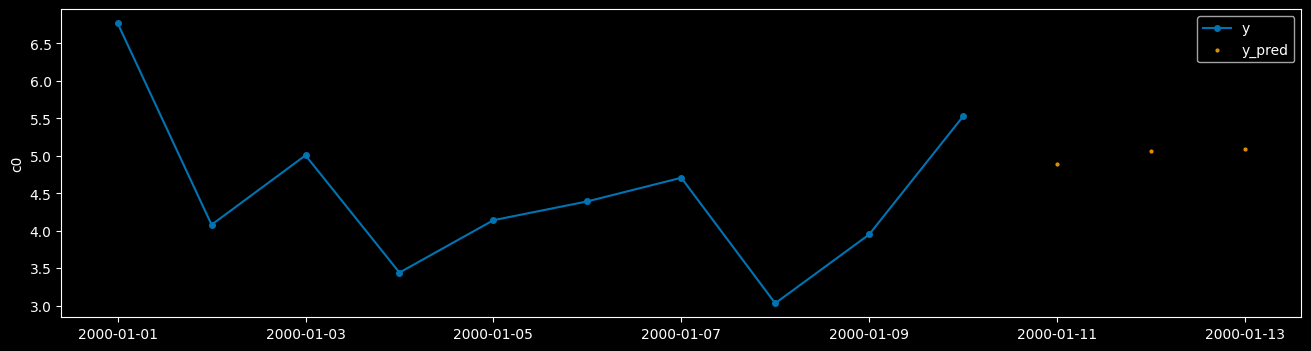

In [39]:
from sktime.utils.plotting import plot_series

plot_series(
    y_test.loc[("h0_99")],
    y_pred.loc[("h0_99")],
    labels=["y", "y_pred"],
)

#### Global Forecasting with exogeneous data

When we predict with exogeneous data, we need to pass both `X` and `y` to `predict`.

`X` must contain all historical values and the time points to be predicted while `y` should only contain the historical values but not the time points to be predicted.

In [40]:
from sktime.utils._testing.hierarchical import _make_hierarchical
from sklearn.model_selection import train_test_split

data = _make_hierarchical(
    hierarchy_levels=(100, 1), max_timepoints=10, min_timepoints=10, n_columns=2
)
data = data.droplevel(1)
x = data["c0"].to_frame()
y = data["c1"].to_frame()
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, train_size=0.9, shuffle=False
)
y_test = y_test.groupby(level=0).apply(lambda x: x.droplevel(0).iloc[:-3])

`X_train` and `y_train` have the same time index from 2000-01-01 to 2000-01-10.

However `y_test` is shorter than `X_test`. 

`X_test` has the time index from 2000-01-01 to 2000-01-10 but `y_test` only has the time index from 2000-01-01 to 2000-01-07. 

This is because we don't know the values from 2000-01-08 to 2000-01-10 of `y_test` which are going to be forecasted.

In [41]:
y_test

c1
h0    time                
h0_90 2000-01-01  4.780531
      2000-01-02  5.978414
      2000-01-03  6.548686
      2000-01-04  5.338200
      2000-01-05  6.006836
...                    ...
h0_99 2000-01-03  8.053620
      2000-01-04  4.436978
      2000-01-05  4.923457
      2000-01-06  5.890375
      2000-01-07  4.791325

[70 rows x 1 columns]

`y_test` is shorter than `X_test` as `y_test` only contains the historical values not the time points to be predicted.

Let's initialize a global forecaster which can handle exogeneous data.

In [42]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingTFT

In [43]:
model = PytorchForecastingTFT(
    trainer_params={
        "max_epochs": 5,  # for quick test
        "limit_train_batches": 10,  # for quick test
    },
    dataset_params={
        "max_encoder_length": 3,
    },
)

In [44]:
model.fit(y=y_train, X=X_train, fh=fh)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 32     | train
4  | 

Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s, v_num=10, train_loss_step=0.860, val_loss=0.840, train_loss_epoch=0.851]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  7.46it/s, v_num=10, train_loss_step=0.860, val_loss=0.840, train_loss_epoch=0.851]


PytorchForecastingTFT(dataset_params={'max_encoder_length': 3},
                      trainer_params={'limit_train_batches': 10,
                                      'max_epochs': 5})

Now we can predict on `y_test` with `X_test`.

In [45]:
y_pred = model.predict(fh=fh, X=X_test, y=y_test)
y_pred

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


c1
h0    time                
h0_90 2000-01-08  4.511477
      2000-01-09  4.569256
      2000-01-10  5.443854
h0_91 2000-01-08  4.420218
      2000-01-09  4.622540
      2000-01-10  4.472002
h0_92 2000-01-08  5.573446
      2000-01-09  5.567162
      2000-01-10  5.533332
h0_93 2000-01-08  4.548194
      2000-01-09  5.527386
      2000-01-10  4.496464
h0_94 2000-01-08  5.551834
      2000-01-09  5.400140
      2000-01-10  5.564801
h0_95 2000-01-08  5.551277
      2000-01-09  5.212989
      2000-01-10  4.522350
h0_96 2000-01-08  5.534757
      2000-01-09  5.515212
      2000-01-10  5.161070
h0_97 2000-01-08  5.520890
      2000-01-09  5.226131
      2000-01-10  5.508586
h0_98 2000-01-08  4.419545
      2000-01-09  5.476169
      2000-01-10  5.368806
h0_99 2000-01-08  5.436559
      2000-01-09  5.524553
      2000-01-10  5.543465

We can plot one series to see the result. As we are using random data and only train the model for a few epochs, we can not expect too much.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='c1'>)

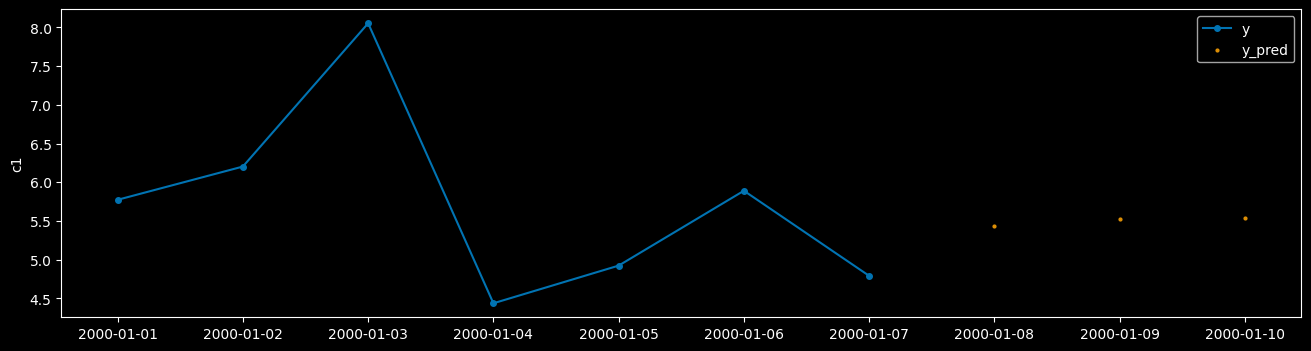

In [46]:
plot_series(
    y_test.loc[("h0_99")],
    y_pred.loc[("h0_99")],
    labels=["y", "y_pred"],
)

---
## Building your own hierarchical or global forecaster

Getting started:

* follow the ["implementing estimator" developer guide](https://www.sktime.net/en/stable/developer_guide/add_estimators.html)
* use the advanced [forecasting extension template](https://github.com/sktime/sktime/blob/main/extension_templates/forecasting.py)

Extension template = python "fill-in" template with to-do blocks that allow you to implement your own, sktime-compatible forecasting algorithm.

Check estimators using `check_estimator`

For hierarchical forecasting:

* ensure to pick supported mtypes for panel and hierarchical data
* recommended: `y_inner_mtype = ["pd.DataFrame", "pd-multiindex", "pd_multiindex_hier"]`, same for `X_inner_mtype`
    * this ensures the inputs `y`, `X` seen in `_fit`, `_predict` are `pd.DataFrame`, with 1, 2, 3 or more row levels
* you can implement vectorization over rows if efficient implementation is available
    * but: automated vectorization already loops over row index sets, don't implement that if that's what "hierarchical" is
    * to ensure automated vectorization, do *not* include Hierarchical or Panel mtypes in `y_inner_mtype`, `X_inner_mtype`
* think carefully whether your estimator is a forecaster, or can be decomposed in a transformer
    * "do X and then apply forecaster already in sktime" is a strong hint that you actually want to implement a transformer


---

### Credits

notebook creation: danbartl, fkiraly

hierarchical forecasting framework: ciaran-g, fkiraly\
reduction compatibility with hierarchical forecasting: danbartl\
window summarizer, reduction with transform-from-y: danbartl\
aggregation and reconciliation: ciaran-g\
global forecast: Xinyu Wu